# Regression

=== VALIDATION (log) ===

[IND] Weighted late-fusion (inverse-MSE on VAL)
  text+meta       | w=[0.326, 0.674] | per-mod MSE: text=12.218080, meta=5.906535 | fused MSE: 5.423484 | PC: 0.7791
  meta+video      | w=[0.693, 0.307] | per-mod MSE: meta=5.906535, video=13.354725 | fused MSE: 5.641422 | PC: 0.7711
  video+text      | w=[0.478, 0.522] | per-mod MSE: video=13.354725, text=12.218080 | fused MSE: 11.812564 | PC: 0.3665
  all_three       | w=[0.23, 0.251, 0.519] | per-mod MSE: video=13.354725, text=12.218080, meta=5.906535 | fused MSE: 6.045314 | PC: 0.7722

[DEP] Weighted late-fusion (inverse-MSE on VAL)
  text+meta       | w=[0.211, 0.789] | per-mod MSE: text=10.576710, meta=2.822301 | fused MSE: 3.176198 | PC: 0.9284
  meta+video      | w=[0.805, 0.195] | per-mod MSE: meta=2.822301, video=11.634991 | fused MSE: 2.611290 | PC: 0.9395
  video+text      | w=[0.476, 0.524] | per-mod MSE: video=11.634991, text=10.576710 | fused MSE: 7.119252 | PC: 0.8411
  all_three       | w=[0.161

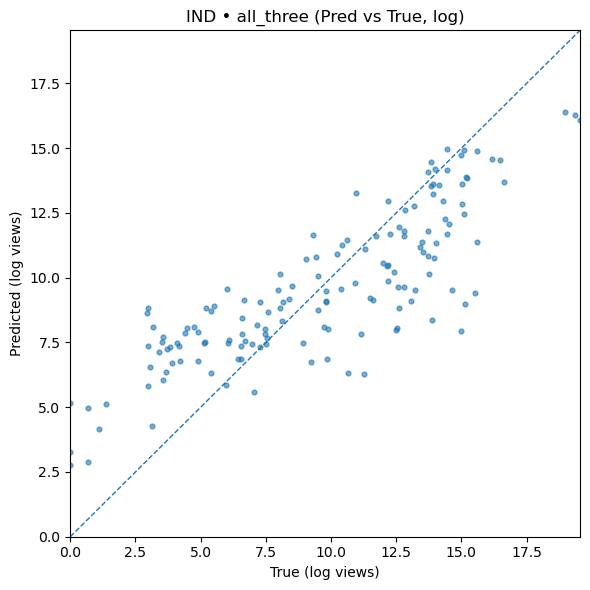

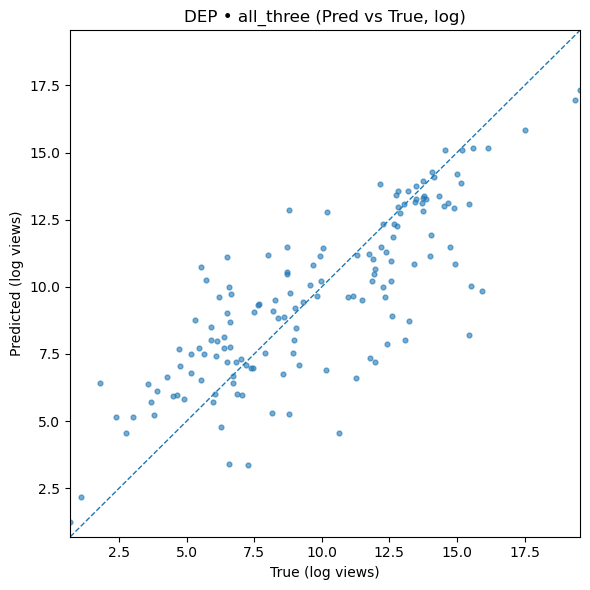

In [8]:
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

RESULTS_DIR = Path("results_final")

FILES_TEST = {
    "dep": {"video": RESULTS_DIR / "video_reg_test_dep.csv",
            "text":  RESULTS_DIR / "text_reg_test_dep.csv",
            "meta":  RESULTS_DIR / "metadata_reg_test_dep.csv"},
    "ind": {"video": RESULTS_DIR / "video_reg_test_ind.csv",
            "text":  RESULTS_DIR / "text_reg_test_ind.csv",
            "meta":  RESULTS_DIR / "metadata_reg_test_ind.csv"},
}
FILES_VAL = {
    "dep": {"video": RESULTS_DIR / "video_reg_val_dep.csv",
            "text":  RESULTS_DIR / "text_reg_val_dep.csv",
            "meta":  RESULTS_DIR / "metadata_reg_val_dep.csv"},
    "ind": {"video": RESULTS_DIR / "video_reg_val_ind.csv",
            "text":  RESULTS_DIR / "text_reg_val_ind.csv",
            "meta":  RESULTS_DIR / "metadata_reg_val_ind.csv"},
}

COMBOS = [
    ("text+meta",   ["text","meta"]),
    ("meta+video",  ["meta","video"]),
    ("video+text",  ["video","text"]),
    ("all_three",   ["video","text","meta"]),
]

def _read(p): 
    return pd.read_csv(Path(p))

def safe_pc(y, p):
    y = np.asarray(y, float); p = np.asarray(p, float)
    m = np.isfinite(y) & np.isfinite(p) 
    y, p = y[m], p[m]
    if y.size < 2 or np.isclose(y.std(), 0) or np.isclose(p.std(), 0): 
        return float("nan")
    return float(np.corrcoef(y, p)[0, 1])

def _merge_three(paths):
    def norm(df, tag, path):
        if "y_pred" in df.columns: 
            df = df.rename(columns={"y_pred": f"{tag}_pred"})
        else: 
            raise KeyError(f"{path}: need 'y_pred' column.")
        if "video_id" not in df.columns: 
            raise KeyError(f"{path}: missing 'video_id'.")
        return df

    # Rename the columns
    v = norm(_read(paths["video"]), "video", paths["video"])   
    t = norm(_read(paths["text"]),  "text",  paths["text"])
    m = norm(_read(paths["meta"]),  "meta",  paths["meta"])
    df = v.merge(t, on="video_id", how="inner").merge(m, on="video_id", how="inner") # Merge on video id

    ycols = [c for c in df.columns if c == "y_true"]   # Get the y tru columns from all
    if not ycols: 
        raise KeyError("No y_true column after merge.")
    y_ref = df[ycols[0]].astype(float)
    
    # Ensure that the y_true column is the same in all 3
    for c in ycols[1:]:
        delta = float(np.nanmax(np.abs(df[c].astype(float) - y_ref)))
        if delta > 1e-6:
            print(f"⚠️ y_true mismatch vs {c}: max |Δ|={delta:.6f}")
    df = df.drop(columns=ycols, errors="ignore")
    df["y_true"] = y_ref.values

    cols = ["y_true","video_pred","text_pred","meta_pred"]  # Final y_true with all 3 preds
    mask = np.isfinite(df[cols].to_numpy(float)).all(axis=1)
    if (~mask).any(): print(f"⚠️ Dropped {(~mask).sum()} rows with NaN/Inf.")
    return df.loc[mask, ["video_id","y_true","video_pred","text_pred","meta_pred"]].reset_index(drop=True)

# Inverse-MSE weights for the given columns (log space)
def _inv_mse_weights_for_combo(y, P):
    mses = ((P - y[:, None])**2).mean(axis=0)   # MSE
    inv  = 1.0 / np.clip(mses, 1e-12, None)   # guard against div by zero
    w    = inv / inv.sum()      # normalize to sum to 1
    return w, mses

def _metrics(y, p):
    y = np.asarray(y, float) 
    p = np.asarray(p, float)
    return float(np.mean((p - y)**2)), safe_pc(y, p)   # Return MSE, PC

# Plot true vs predictions graph
def _plot_pred_vs_true(y, yhat, title):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat); y, yhat = y[m], yhat[m]
    if y.size == 0:
        print("Skipped plot: no finite points."); 
        return
    lo = float(min(y.min(), yhat.min())) 
    hi = float(max(y.max(), yhat.max()))
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        print("Skipped plot : invalid axis limits.") 
        return
    plt.figure(figsize=(6,6))
    plt.scatter(y, yhat, s=12, alpha=0.6)
    plt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)
    plt.xlim(lo, hi) 
    plt.ylim(lo, hi)
    plt.xlabel("True (log views)") 
    plt.ylabel("Predicted (log views)")
    plt.title(title) 
    plt.tight_layout()

def run_all():
    # 1) VALIDATION 
    weights = {}  # weights[(split,label)] = (w, mses_v)
    print("=== VALIDATION (log) ===")
    for split in ["ind", "dep"]:
        dfv = _merge_three(FILES_VAL[split])   # Merge all 3 files
        print(f"\n[{split.upper()}] Weighted late-fusion (inverse-MSE on VAL)")
        for label, mods in COMBOS:
            cols = [f"{m}_pred" for m in mods]      # modality columns to fuse
            yv = dfv["y_true"].to_numpy(float)
            Pv = dfv[cols].to_numpy(float)         # VAL predictions per modality
            w, mses_v = _inv_mse_weights_for_combo(yv, Pv)   # Get the weights
            fv = Pv @ w            # fused VAL predictions - matrix-vector multiplication
            mse_v, pc_v = _metrics(yv, fv)      # report VAL fused metrics
            per_mod_str = ", ".join([f"{m}={mses_v[i]:.6f}" for i, m in enumerate(mods)])
            print(f"  {label:<15} | w={np.round(w,3).tolist()} | per-mod MSE: {per_mod_str} "
                  f"| fused MSE: {mse_v:.6f} | PC: {pc_v:.4f}")
            weights[(split, label)] = (w, mses_v)   # save for TEST

    # 2) TEST - Use weights from VAL
    print("\n=== TEST (log; using VAL weights) ===")
    for split in ["ind", "dep"]:
        dft = _merge_three(FILES_TEST[split])    # load & align TEST predictions
        yt  = dft["y_true"].to_numpy(float)     # TEST ground truth (log)
        print(f"\n[{split.upper()}]")
        for label, mods in COMBOS:
            w, _ = weights[(split, label)]     # reuse VAL-learned weights
            Pt = dft[[f"{m}_pred" for m in mods]].to_numpy(float)   # TEST predictions
            ft = Pt @ w                    # fused TEST predictions
            mse_t, pc_t = _metrics(yt, ft)   # Return test predictions for combos
            print(f"  {label:<15} | fused MSE: {mse_t:.6f} | PC: {pc_t:.4f}")

            # Only make plots for the final fusion of all three
            if label == "all_three":
                base = f"reg_test_{split}_{label.replace('+','_')}"
                _plot_pred_vs_true(
                    yt, ft,
                    f"{split.upper()} • {label} (Pred vs True, log)"
                )

run_all()

# Classification

=== VALIDATION (compute weights & fused metrics) ===

[IND] VAL — weights by accuracy and fused performance
  video+text  | w=[0.562, 0.438] | per-mod accuracy: video=0.5400, text=0.4200 | fused Acc: 0.5400 | F1: 0.4381
  video+meta  | w=[0.54, 0.46] | per-mod accuracy: video=0.5400, meta=0.4600 | fused Acc: 0.5400 | F1: 0.4381
  text+meta   | w=[0.477, 0.523] | per-mod accuracy: text=0.4200, meta=0.4600 | fused Acc: 0.4600 | F1: 0.4332
  all_three   | w=[0.38, 0.296, 0.324] | per-mod accuracy: video=0.5400, text=0.4200, meta=0.4600 | fused Acc: 0.4800 | F1: 0.3962

[DEP] VAL — weights by accuracy and fused performance
  video+text  | w=[0.5, 0.5] | per-mod accuracy: video=0.5686, text=0.5686 | fused Acc: 0.5686 | F1: 0.5550
  video+meta  | w=[0.426, 0.574] | per-mod accuracy: video=0.5686, meta=0.7647 | fused Acc: 0.7647 | F1: 0.7590
  text+meta   | w=[0.426, 0.574] | per-mod accuracy: text=0.5686, meta=0.7647 | fused Acc: 0.7647 | F1: 0.7590
  all_three   | w=[0.299, 0.299, 0.402] | 

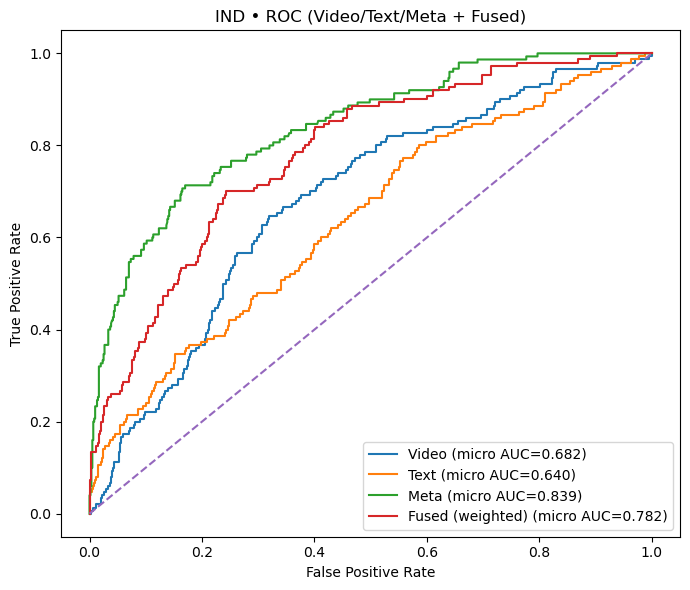

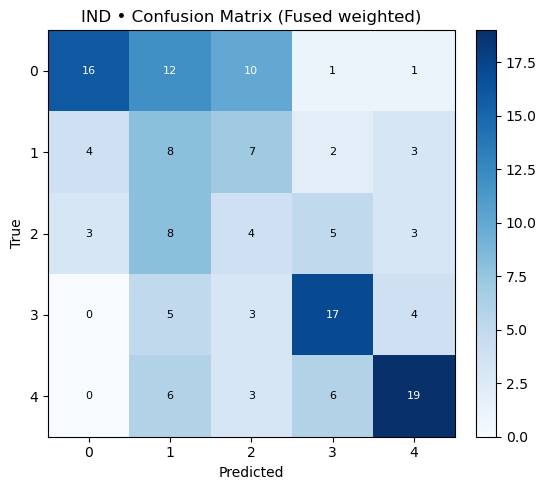

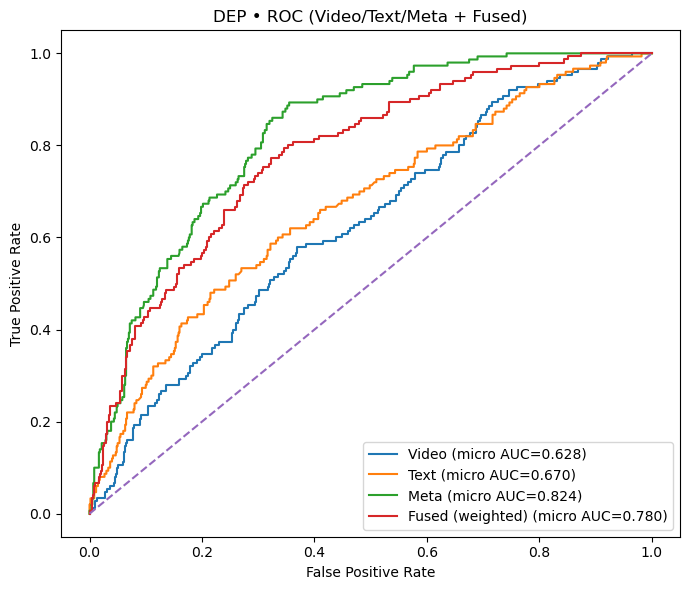

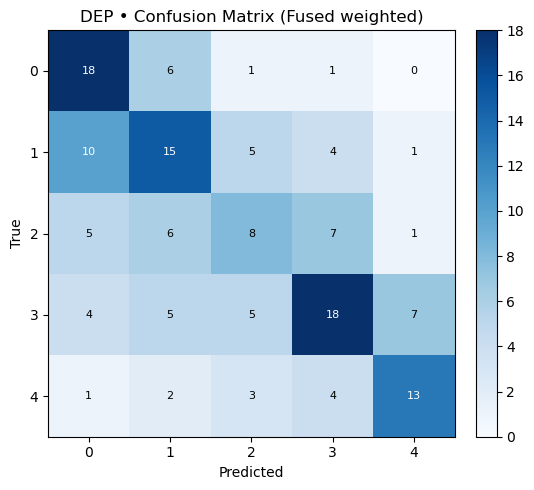

In [2]:
import numpy as np, pandas as pd, re
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize

RESULTS_DIR = Path("results_final")

FILES_VAL = {
    "dep": {"video": RESULTS_DIR / "video_cls_val_dep.csv",
            "text":  RESULTS_DIR / "text_cls_val_dep.csv",
            "meta":  RESULTS_DIR / "metadata_cls_val_dep.csv"},
    "ind": {"video": RESULTS_DIR / "video_cls_val_ind.csv",
            "text":  RESULTS_DIR / "text_cls_val_ind.csv",
            "meta":  RESULTS_DIR / "metadata_cls_val_ind.csv"},
}
FILES_TEST = {
    "dep": {"video": RESULTS_DIR / "video_cls_test_dep.csv",
            "text":  RESULTS_DIR / "text_cls_test_dep.csv",
            "meta":  RESULTS_DIR / "metadata_cls_test_dep.csv"},
    "ind": {"video": RESULTS_DIR / "video_cls_test_ind.csv",
            "text":  RESULTS_DIR / "text_cls_test_ind.csv",
            "meta":  RESULTS_DIR / "metadata_cls_test_ind.csv"},
}

COMBOS = [
    ("video+text", ["video","text"]),
    ("video+meta", ["video","meta"]),
    ("text+meta",  ["text","meta"]),
    ("all_three",  ["video","text","meta"]),
]

def _read(p): 
    return pd.read_csv(Path(p))

def _softmax(Z, axis=1):
    Z = np.asarray(Z, float)   # ensure float array
    Z = Z - np.max(Z, axis=axis, keepdims=True)  # subtract max for stability
    np.exp(Z, out=Z)      # exponentiate in-place
    den = Z.sum(axis=axis, keepdims=True) # row/axis sums
    den[den == 0] = 1.0    # guard against division by 0
    return Z / den       # normalized softmax

def _std_modality_df(df, modality):
    if "video_id" not in df.columns:
        raise KeyError("missing video_id")
    ycols = [c for c in df.columns if c == "y_true"]  # y_true
    if not ycols:
        raise KeyError("missing y_true")
    y = df[ycols[0]].astype(int).to_numpy() # pick the first y_true-like column

    # hard preds
    hard = None
    for c in ["y_pred", "pred"]:
        if c in df.columns:
            hard = df[c].astype(int).to_numpy()
            break

    # probs / scores
    cols = list(df.columns)
    patterns = [
        (r"^prob_(\d+)$",        lambda c: int(re.findall(r"\d+", c)[0]), False),
        (r"^prob_c(\d+)$",       lambda c: int(re.findall(r"\d+", c)[0]), False),
    ]
    P = None
    for pat, to_idx, needs_sm in patterns:
        matches = [c for c in cols if re.fullmatch(pat, str(c))]  # find columns matching the pattern
        if matches:
            matches = sorted(matches, key=to_idx)    # order by class index
            A = df[matches].to_numpy(float)        # NxC matrix
            if needs_sm: 
                A = _softmax(A, axis=1)      # convert logits → probs
            s = A.sum(axis=1, keepdims=True) # normalize rows
            s[s==0]=1.0
            P = A / s
            col_ids = [to_idx(c) for c in matches]    # class ids for each column
            return _pack_std(df["video_id"], y, hard, P, col_ids, modality) # pack & return standardized frame for this modality

    # No prob columns → just hard preds
    return _pack_std(df["video_id"], y, hard, None, None, modality)

# Assemble standardized DataFrame for a modality; ensure y_pred exists; align prob columns to 0..K-1.
def _pack_std(video_id_series, y, hard, P, col_ids, mod):
    out = pd.DataFrame({"video_id": video_id_series.values, "y_true": y})
    if hard is None and P is not None:
        hard = P.argmax(axis=1).astype(int)  # infer hard preds from probs
    if hard is None:
        raise KeyError("no y_pred/pred and no probabilities/scores found")
    out[f"{mod}_y_pred"] = hard   # store hard predictions
    
    if P is not None:
        # pack as <mod>_prob_k, aligning by class index in col_ids
        K = int(max(y.max(), hard.max())) + 1
        # make NxK zero, then fill known indices
        full = np.zeros((len(y), K), float)
        for j, k in enumerate(col_ids):
            if k < K:
                full[:, k] = P[:, j]
        s = full.sum(axis=1, keepdims=True); s[s==0]=1.0
        full = full / s
        for k in range(K):
            out[f"{mod}_prob_{k}"] = full[:, k]
    return out

# Merge video/text/meta standardized frames on (video_id, y_true)
def _merge_modalities(paths):
    V = _std_modality_df(_read(paths["video"]), "video")
    T = _std_modality_df(_read(paths["text"]),  "text")
    M = _std_modality_df(_read(paths["meta"]),  "meta")
    return V.merge(T, on=["video_id","y_true"], how="inner") \
            .merge(M, on=["video_id","y_true"], how="inner") \
            .reset_index(drop=True)

def _acc_f1(y, yhat):
    return accuracy_score(y, yhat), f1_score(y, yhat, average="macro")

# Return weights (len=mods) computed on VAL using acc or macro-F1.
def _weights_from_val_combo(df, mods, use_macro_f1=False):
    y = df["y_true"].to_numpy(int)
    metric = (lambda a,b: f1_score(a,b,average="macro")) if use_macro_f1 else accuracy_score
    scores = np.array([metric(y, df[f"{m}_y_pred"].to_numpy(int)) for m in mods], float) + 1e-9
    return (scores / scores.sum()), scores

# Return NxK probability matrix for modality; if missing, use one-hot from hard preds.
def _prob_matrix(df, mod, K):
    cols = [c for c in df.columns if c.startswith(f"{mod}_prob_")] # Find standardized prob columns
    if cols:
        cols = sorted(cols, key=lambda c: int(c.split("_")[-1]))  # Sort by class index
        Pm = df[cols].to_numpy(float)  # N×C probs (or partial)
        # pad/truncate to K
        if Pm.shape[1] != K:     # If class count differs, pad into K
            Pfull = np.zeros((Pm.shape[0], K), float)
            for j, c in enumerate(cols):
                k = int(c.split("_")[-1])
                if k < K:
                    Pfull[:, k] = Pm[:, j]
            Pm = Pfull
        s = Pm.sum(axis=1, keepdims=True); s[s==0]=1.0
        return Pm / s
    # fallback: one-hot from hard predictions
    hard = df[f"{mod}_y_pred"].to_numpy(int)
    Pm = np.zeros((len(hard), K), float)
    Pm[np.arange(len(hard)), hard] = 1.0
    return Pm

def _fuse_probs_weighted_combo(df, mods, w):
    y = df["y_true"].to_numpy(int)  # True labels
    K = int(y.max()) + 1
    Psum = np.zeros((len(y), K), float)  # Accumulator for weighted probs
    for m, wj in zip(mods, w):         # For each modality and its weight
        Psum += _prob_matrix(df, m, K) * wj     # Add weighted modality probs
    s = Psum.sum(axis=1, keepdims=True); s[s==0]=1.0   # Normalize fused probs per row
    return Psum / s

def _fuse_hard_weighted_vote(df, mods, w):
    y = df["y_true"].to_numpy(int)
    K = int(y.max()) + 1
    H = np.stack([df[f"{m}_y_pred"].to_numpy(int) for m in mods], axis=1) # Stack hard predictions for each modality → (N, M) where M=len(mods)
    out = np.empty(H.shape[0], dtype=int)  # Allocate output array for fused predictions (N,)
    for i in range(H.shape[0]):  # Loop over samples
        s = np.zeros(K)    # Score bucket per class for this sample
        for j, wj in enumerate(w):  # Loop over modalities with their weights
            s[H[i, j]] += wj  # Add the modality weight to the predicted class bucket
        out[i] = s.argmax()  # Fused class = argmax of weighted votes
    return out         # Return fused hard predictions (N,)

def _eval_combo(df, mods, w):
    y = df["y_true"].to_numpy(int)    # Ground-truth labels (N,)
    # Try probability-level fusion: returns NxK probs or None if unavailable
    Pf = _fuse_probs_weighted_combo(df, mods, w)
    if Pf is not None:
        yhat = Pf.argmax(axis=1)  # Convert fused probabilities to hard labels
        acc, f1 = _acc_f1(y, yhat)
        return yhat, acc, f1, Pf
    yhat = _fuse_hard_weighted_vote(df, mods, w) # Fall back to weighted voting over hard preds
    acc, f1 = _acc_f1(y, yhat)
    return yhat, acc, f1, None

# Plotting
def _micro_roc(y, P):
    K = P.shape[1]
    Y = label_binarize(y, classes=np.arange(K))
    fpr, tpr, _ = roc_curve(Y.ravel(), P.ravel())
    auc = roc_auc_score(Y, P, average="micro", multi_class="ovr")
    return fpr, tpr, auc

def _plot_roc_all(yt, prob_dict, title, out_png):
    plt.figure(figsize=(7,6))
    for name, P in prob_dict.items():
        if P is None:
            continue
        fpr, tpr, auc = _micro_roc(yt, P)
        plt.plot(fpr, tpr, label=f"{name} (micro AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate") 
    plt.ylabel("True Positive Rate")
    plt.title(title) 
    plt.legend(loc="lower right") 
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    print(f"  Saved ROC → {out_png}")

def _plot_confmat(y_true, y_pred, title, out_png):
    cm = confusion_matrix(y_true, y_pred)
    K = cm.shape[0]
    plt.figure(figsize=(6,5))
    im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(K), range(K)); plt.yticks(range(K), range(K))
    for i in range(K):
        for j in range(K):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=8)
    plt.tight_layout() 
    plt.savefig(out_png, dpi=150)
    print(f"  Saved Confusion Matrix → {out_png}")


def run_all(use_macro_f1_for_weights=False):
    basis = "macro-F1" if use_macro_f1_for_weights else "accuracy"

    # Validation
    weights = {}  # weights[(split, label)] = w for that combo
    print("=== VALIDATION (compute weights & fused metrics) ===")
    for split in ["ind", "dep"]:
        dfv = _merge_modalities(FILES_VAL[split])
        print(f"\n[{split.upper()}] VAL — weights by {basis} and fused performance")
        for label, mods in COMBOS:
            w, permod = _weights_from_val_combo(dfv, mods, use_macro_f1=use_macro_f1_for_weights)
            yhat_v, acc_v, f1_v, _ = _eval_combo(dfv, mods, w)
            per_mod_str = ", ".join([f"{m}={permod[i]:.4f}" for i, m in enumerate(mods)])
            print(f"  {label:<11} | w={np.round(w,3).tolist()} | per-mod {basis}: {per_mod_str} "
                  f"| fused Acc: {acc_v:.4f} | F1: {f1_v:.4f}")
            weights[(split, label)] = w

    # Test
    print("\n=== TEST (apply VAL weights) ===")
    for split in ["ind", "dep"]:
        dft = _merge_modalities(FILES_TEST[split])
        yt  = dft["y_true"].to_numpy(int)

        # single modality metrics
        print(f"\n[{split.upper()}] TEST — single modalities")
        for m in ["video","text","meta"]:
            acc, f1 = _acc_f1(yt, dft[f"{m}_y_pred"].to_numpy(int))
            print(f"  {m.capitalize():<7} → Acc: {acc:.4f} | F1-macro: {f1:.4f}")

        # pairwise + all-three weighted fusion
        print(f"[{split.upper()}] TEST — weighted fusion (VAL weights)")
        Pfused_all = None; yhat_all = None  # for plots
        prob_dict = { "Video": _prob_matrix(dft, "video", int(yt.max())+1),
                      "Text":  _prob_matrix(dft, "text",  int(yt.max())+1),
                      "Meta":  _prob_matrix(dft, "meta",  int(yt.max())+1) }

        for label, mods in COMBOS:
            w = weights[(split, label)]  # Weights on val
            yhat_t, acc_t, f1_t, Pf = _eval_combo(dft, mods, w)
            print(f"  {label:<11} → Acc: {acc_t:.4f} | F1-macro: {f1_t:.4f}")
            if label == "all_three":
                Pfused_all = Pf
                yhat_all   = yhat_t

        # plots for TEST 
        if Pfused_all is not None:
            prob_dict["Fused (weighted)"] = Pfused_all
        _plot_roc_all(yt, prob_dict, f"{split.upper()} • ROC (Video/Text/Meta + Fused)",
                      RESULTS_DIR / f"cls_roc_test_{split}.png")
        _plot_confmat(yt, yhat_all, f"{split.upper()} • Confusion Matrix (Fused weighted)",
                      RESULTS_DIR / f"cls_cm_test_{split}_fused.png")

if __name__ == "__main__":
    run_all(use_macro_f1_for_weights=False)